In [1]:
import torch
import numpy as np
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader
import sys
import geotorch
from itertools import cycle
from tqdm.auto import trange
from tqdm.notebook import tqdm

sys.path.append('../')
from matplotlib import cm
import matplotlib.pyplot as plt

from utils import plot_utils, s3w_utils, vmf_utils, utils
from utils.nf import normalizing_flows
from methods import s3w, ssw, sw

from experiments import gf_particles, gd_sphere

from scipy.stats import gaussian_kde

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

In [2]:
mu_target = [0,1,0,0,0,0,0,0,0]
mu_target = mu_target / np.linalg.norm(mu_target)

kappa_target = 10

X_target = torch.tensor(vmf_utils.rand_vmf(mu_target, kappa=kappa_target, N=30000), dtype=torch.float)


## Gradient Flow on Particles

In [64]:
X0 = torch.randn((300, 9), device=device)
X0 = F.normalize(X0, p=2, dim=-1)
X0.requires_grad_(True)
L = [X0.clone()]
L_loss = []

In [62]:
d_func = s3w.ari_s3wd 
d_args = {'p': 2, 'n_projs': 100, 'device': device, 'n_rotations': 5000, 'pool_size':5000}

L, L_loss = gf_particles.run_exp(X_target, X0, d_func , d_args, device, n_steps=201, lr=5, batch_size=300)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:09<00:00, 22.27it/s, Loss = 0.132]


In [65]:
d_func = s3w.ri_s3wd 
d_args = {'p': 2, 'n_projs': 100, 'device': device, 'n_rotations': 5000}

L, L_loss1 = gf_particles.run_exp(X_target, X0, d_func , d_args, device, n_steps=201, lr=0.3, batch_size=300)

  3%|████▏                                                                                                                                       | 6/201 [00:13<07:11,  2.21s/it, Loss = 2.676]


KeyboardInterrupt: 

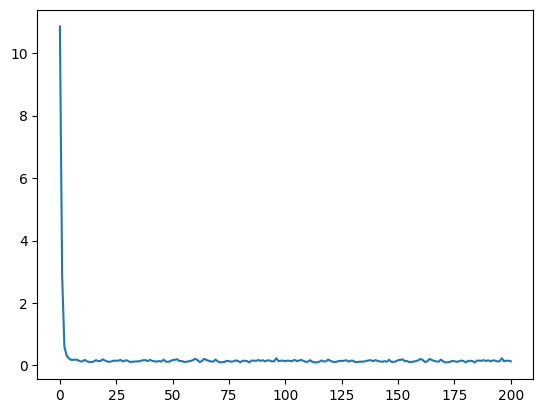

In [63]:
plt.plot(L_loss)

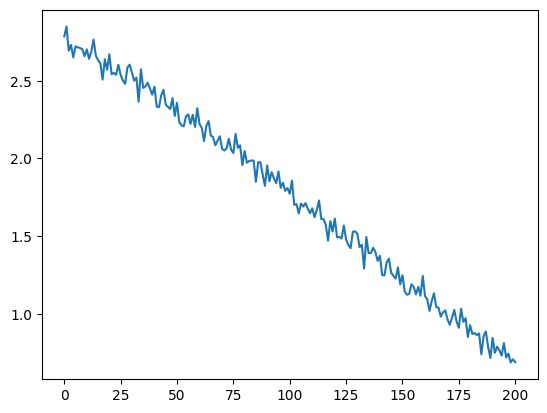

In [27]:
plt.plot(L_loss1)

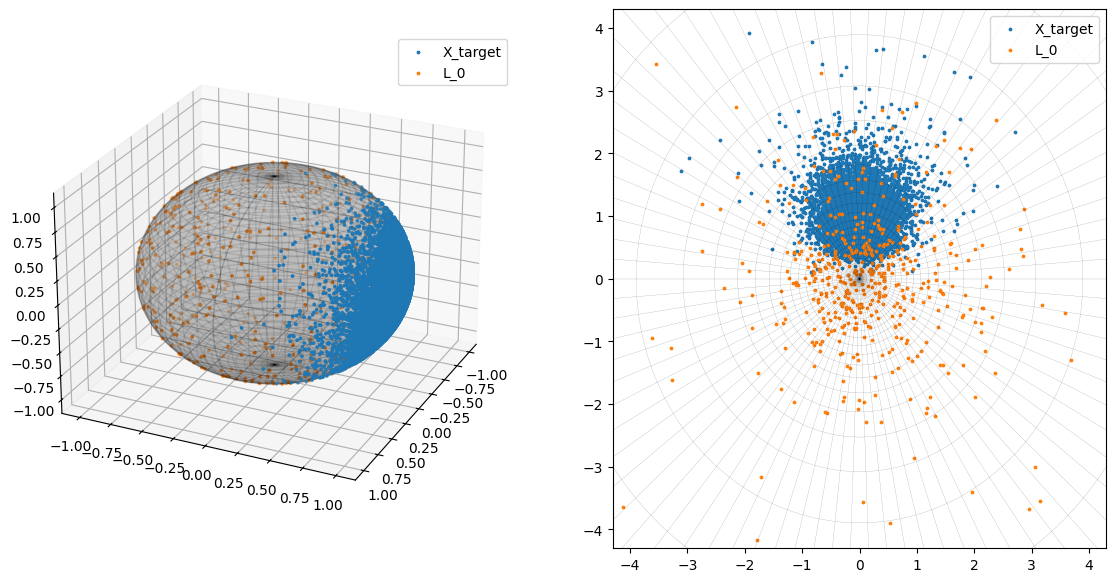

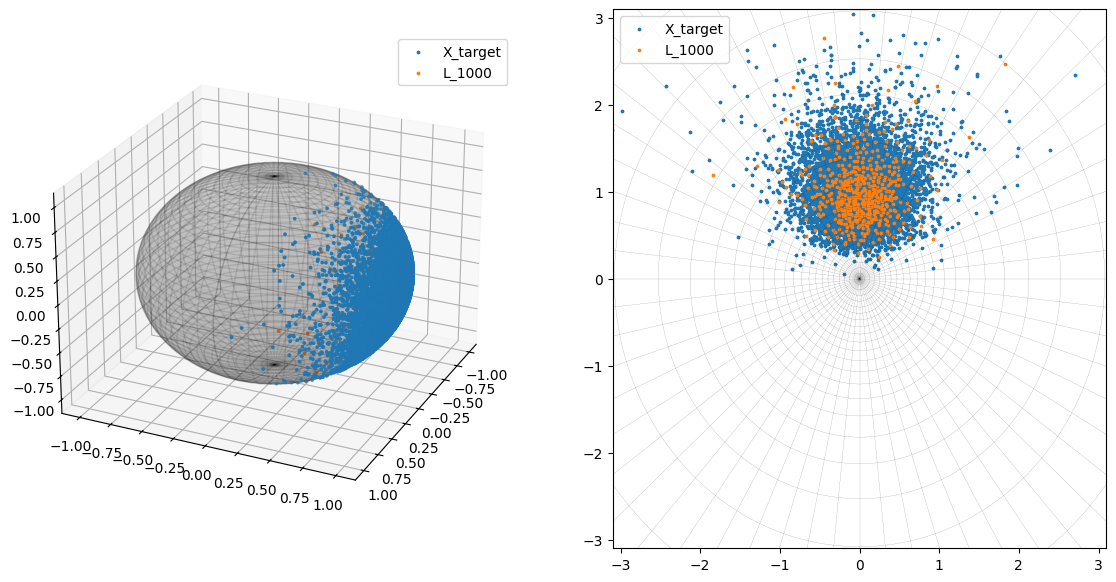

In [5]:
for k in [0, 1000]:
    X_target_cpu = X_target.cpu().detach().numpy()
    L_k_cpu = L[k].cpu().detach().numpy()

    datasets = [X_target_cpu, L_k_cpu]
    labels = ['X_target', f'L_{k}']

    plot_utils.plot_all(datasets, labels, view_init=(25, 25))

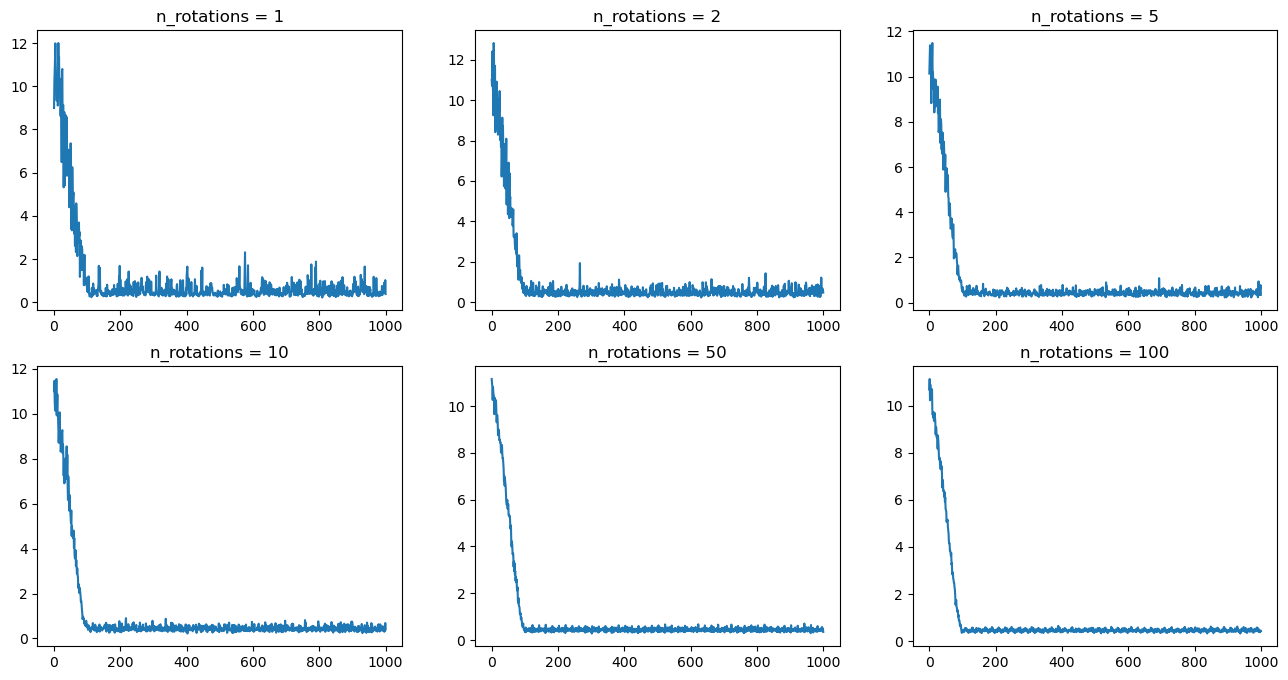

In [17]:
# Create plots of the 6 different loss curves
fig, ax = plt.subplots(2, 3, figsize=(16, 8))
ax[0, 0].plot(L_loss1)
ax[0, 0].set_title('n_rotations = 1')
ax[0, 1].plot(L_loss2)
ax[0, 1].set_title('n_rotations = 2')
ax[0, 2].plot(L_loss5)
ax[0, 2].set_title('n_rotations = 5')
ax[1, 0].plot(L_loss10)
ax[1, 0].set_title('n_rotations = 10')
ax[1, 1].plot(L_loss50)
ax[1, 1].set_title('n_rotations = 50')
ax[1, 2].plot(L_loss100)
ax[1, 2].set_title('n_rotations = 100')
plt.savefig('gf_loss_curves.png')
plt.show()

In [19]:
utils.compute_paalc(L_loss100, 1001, max(L_loss100))

91.45164948260603

In [27]:
d_func = ssw.sswd 
d_args = {'p': 2, 'num_projections': 100, 'device': device}

L, L_loss = gf_particles.run_exp(X_target, X0, d_func , d_args, device, n_steps=1001, lr=100, batch_size=500)

  0%|          | 0/1001 [00:00<?, ?it/s]100%|██████████| 1001/1001 [01:03<00:00, 15.87it/s, Loss = 0.000]


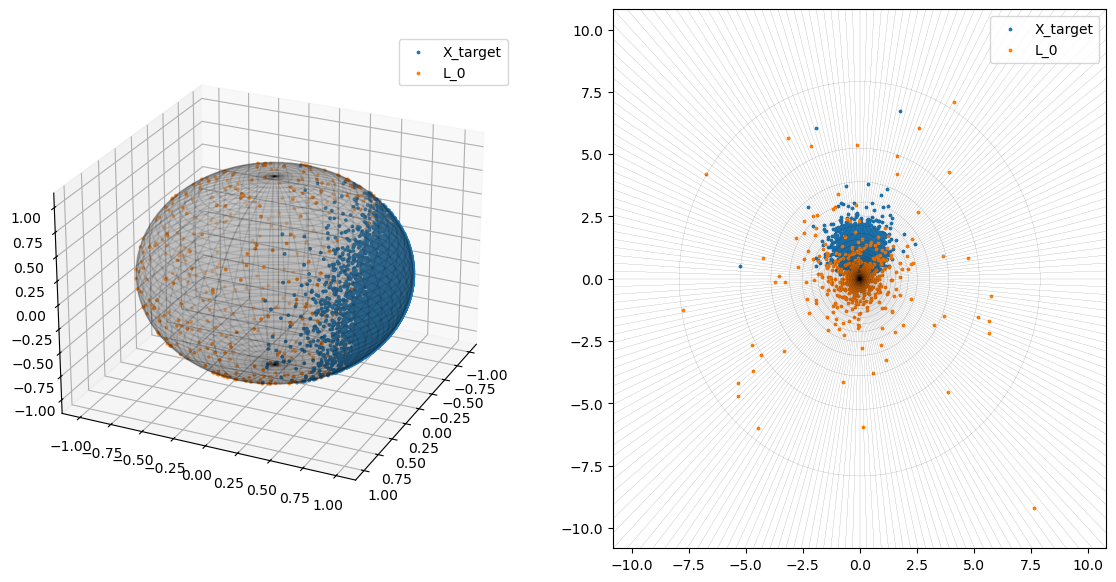

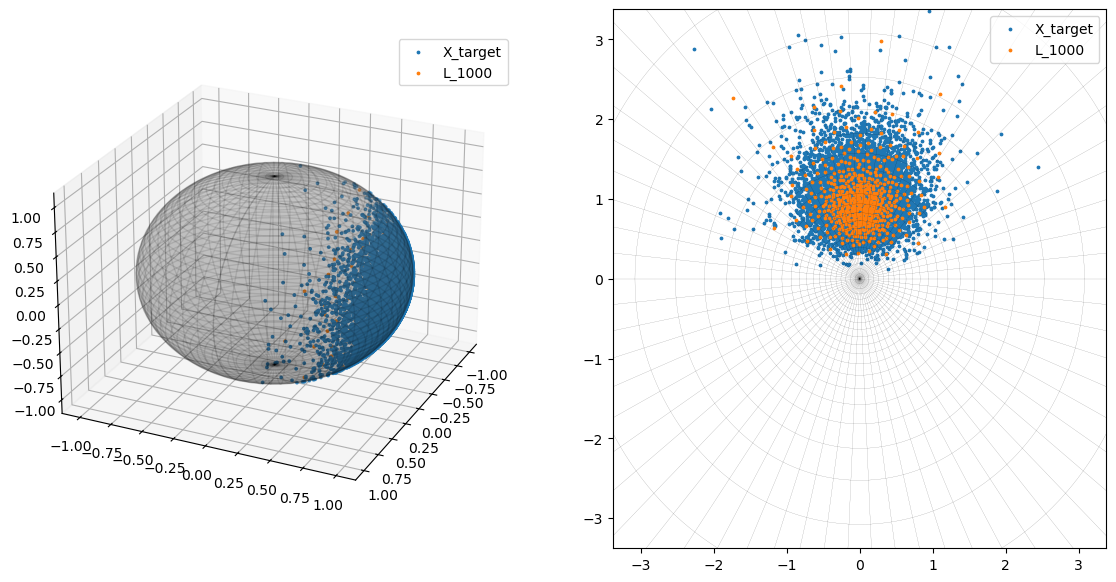

In [28]:
for k in [0, 1000]:
    X_target_cpu = X_target.cpu().detach().numpy()
    L_k_cpu = L[k].cpu().detach().numpy()

    datasets = [X_target_cpu, L_k_cpu]
    labels = ['X_target', f'L_{k}']

    plot_utils.plot_all(datasets, labels, view_init=(25, 25))

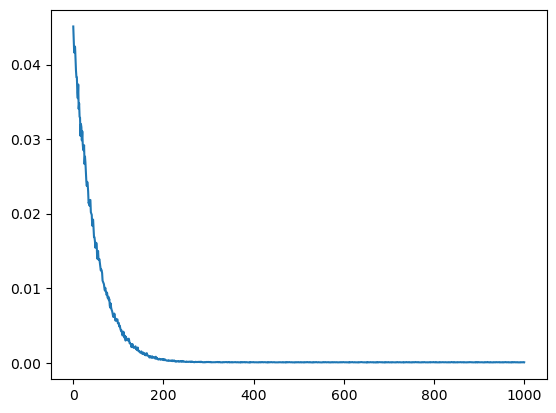

In [29]:
plt.plot(L_loss)
plt.show()

In [30]:
utils.compute_paalc(L_loss, 1001, max(L_loss))

95.2907199311322